---
title: "Network Simulation"
author: "Juan Castro Fernandez"
date: 'March 5, 2020'
output: pdf_document
lang: en
subject: Markdown
subtitle: CS166 Assignment 3
fontsize:
- 22pt
keywords:
- Markdown
- Example
titlepage: yes
...

Original update rules:

1. People change their opinions to more closely match those of people they have strong relationship with.

    A random edge is selected from the network (random interaction between two people). The opinion of the two people gets updated to move closer to each other, depending on the strength of their relationship.
    
    The change in opinion of Person $i$ when interacting with Person $j$ is
    
    $$\Delta o_i = \alpha w_{ij}(o_j-o_i)$$
    
    where $\alpha \in (0,0.5])$ is the parameter of the model (the larger the $alpha$, the faster the change happens). The same change applies for $j$ in the opposite direction. 
    
2. People strenghten or weaken their relationships depending on their level of agreement. The weight of the edge (representing the strength of the relationship) changes also during the interaction represented by the randomly chosen edge in step 1. The change is defined by

    $$\Delta w_{ij} = \beta w_{ij} (1-w_{ij})(1-\gamma |o_i - o_j|)$$
    
    where $\beta \in (0,1)$, and $\gamma \in (0,5)$. If $\gamma \leq 1$,  all weights converge to 1 over time since differing opinions don't matter enough to decrease edge weights. If $\gamma > 1$, the weight between two nodes will decrease if the opinions of the nodes are different enough -- if $|o_i - o_j| > \gamma^{-1}$.
    
    We remove an edge if its weight drops below 0.05.
    
3. New social connections appear randomly for around 1 step in every 100 (more precisely, at each step with a probability of 0.01). The edge weight of this randomly formed new connection is set at 0.5 in these cases. Over time this gets updated according to the first two rules.

The default parameter values are $\alpha = 0.03, \beta = 0.3, \gamma = 4$.
    

Proposed modifications:

1. Meeting new people based on current relationships with people. In real life, meeting new people is usually not random. It is often the case that the new people you meet are introduced to you by other people you already know. However, it is true that sometimes new connections can be made randomly. Therefore, I propose that to add a new connection we follow the follwoing procedure:

    1. We choose a random edge
    2. We randomly assign one node to be the "introducer" and the other the "introduced". The "introducer" is the person that will introduce the "introducer" to one of her friends. 
    3. With probability $q$ we randomly choose a neighboring node of the "introducer" that is not a neighbor of the "introduced" and then create a connection between the "introduced" and that neighbor. If all neighbors of the "introducer" are also neighbors of the "introduced", we pick a new edge and choose new "introducer" and "introduced". With probability $1-q$ we follow the procedure of the original model that randomly creates new connections. 
    4. If the connection was created by a pair of "introducer" and "introduced", then the weight of the connection will depend on the connection between the "introducer" and his neighbor. We choose a parameter $\theta \in [0.5,1]$ that multiplies the previous weight $w_{introducer-neighbor}$ between the introducer and the neighbor that is going to be introduced, and the new connection is assigned $\theta w_{introducer-neighbor}$. If the new connection was made randomly, as in the original procedure, the weight is assigned to 0.2 (since we would expect the new random relationships not to be very strong).
    
2. Introducing a "persuasiveness" and "passionate" parameter.
    (Explain)

In [3]:
from matplotlib import pyplot as plt
import networkx as nx
import random

In [72]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4, theta = 0.75, q = 1):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.theta = theta
        self.q = q
        self.randomnews = 0
        self.introducednews = 0

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
            self.graph.nodes[node]['persuasiveness'] = random.random()
            self.graph.nodes[node]['passion'] = random.random()
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        if random.uniform(0, 1) < 0.01:
            nodes = list(self.graph.nodes)
            created_new = False
            if random.random() < self.q:
                # Create a new edge using the introducer and introduced procedure
                count = 0
                while True:
                    count+=1
                    new_edge = random.sample(nodes, 2)
                    if new_edge in self.graph.edges:
                        introducer = new_edge[0]
                        introduced = new_edge[1]
                        introducer_friends = set(self.graph.neighbors(introducer))
                        introduced_friends = set(self.graph.neighbors(introduced))
                        potential_friends = introducer_friends-introduced_friends-set([introduced])
                        if potential_friends or count>2000:
                            break
                        #here check whether this creates an infinite loop
                if potential_friends:
                    new_friend = random.choice(list(potential_friends))
                    w_introducer = self.graph.edges[introducer,new_friend]['weight']
                    self.graph.add_edge(introduced,new_friend, weight = self.theta*w_introducer)
                    created_new = True
                    self.introducednews += 1
                else:
                    print('Did not create new edges') #check whether new edge connection was not found with this procedure
                
            if not created_new:
                self.randomnews+=1
                # Create a random new edge with weight 0.2 between two unconnected nodes
                while True:
                    new_edge = random.sample(nodes, 2)
                    if new_edge not in self.graph.edges:
                        break
                self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

introduced new connections = 1.0
random new connections = 0.0


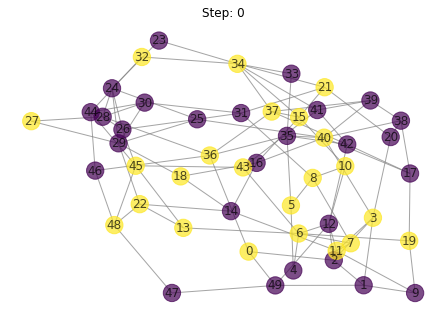

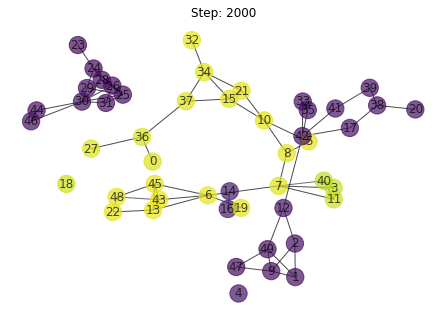

introduced new connections = 1.0
random new connections = 0.0


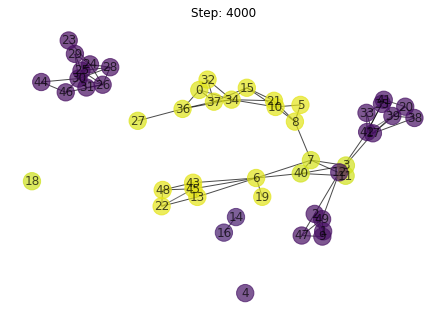

introduced new connections = 1.0
random new connections = 0.0


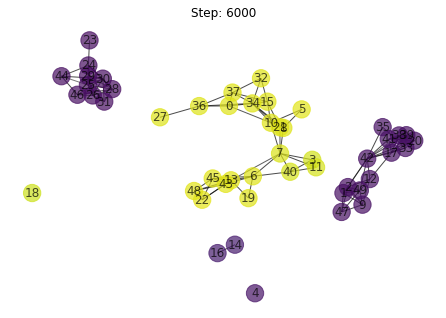

introduced new connections = 1.0
random new connections = 0.0


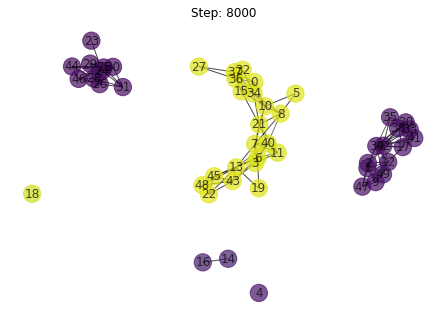

introduced new connections = 1.0
random new connections = 0.0


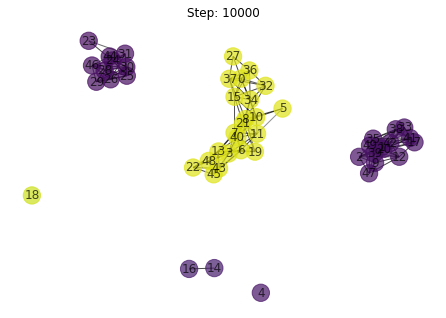

introduced new connections = 1.0
random new connections = 0.0


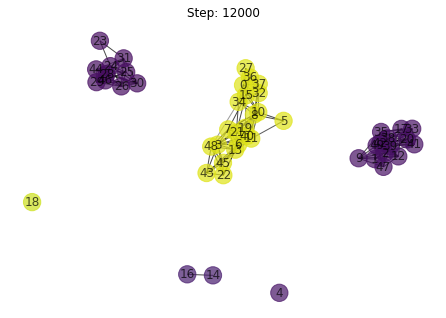

introduced new connections = 1.0
random new connections = 0.0


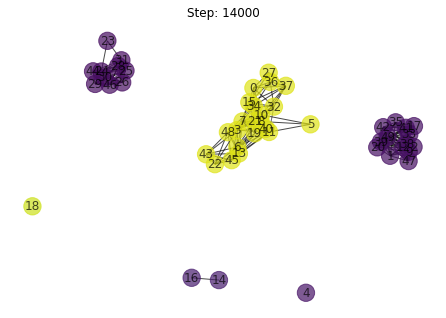

introduced new connections = 1.0
random new connections = 0.0


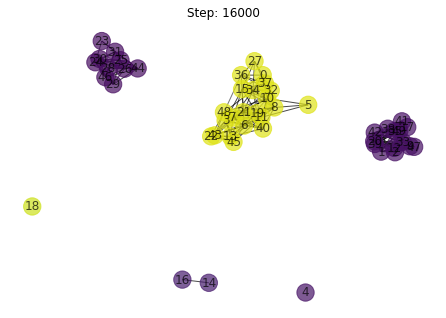

introduced new connections = 1.0
random new connections = 0.0


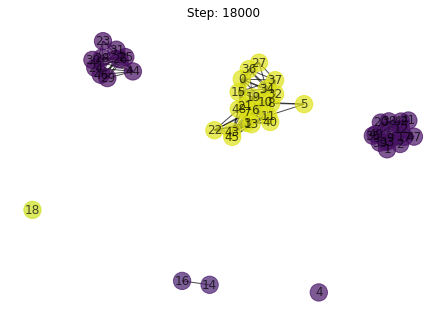

introduced new connections = 1.0
random new connections = 0.0


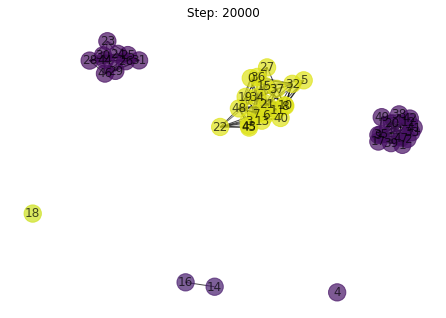

In [73]:
sim = SocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update()
    print('introduced new connections = {}'.format(sim.introducednews/(sim.introducednews+sim.randomnews)))
    print('random new connections = {}'.format(sim.randomnews/(sim.introducednews+sim.randomnews)))
    plt.figure()
    sim.observe()
    plt.show()